## Importing libraries

In [190]:
import numpy as np
from matplotlib import image
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns

## Loading image

In [191]:
# main_img = image.imread('master-pnp-prok-01800-01886a.tif').astype('uint32')
# main_img = image.imread('master-pnp-prok-00400-00458a.tif').astype('uint32')
main_img = image.imread('master-pnp-prok-01800-01833a.tif').astype('uint32')

In [192]:
main_img.shape

(9647, 3692)

To crop the image into 3 pieces, we remove 1 or 2 rows (at most) to make the height dividable by 3

In [193]:
main_img = main_img[:main_img.shape[0]-(main_img.shape[0]%3), :]
main_img.shape

(9645, 3692)

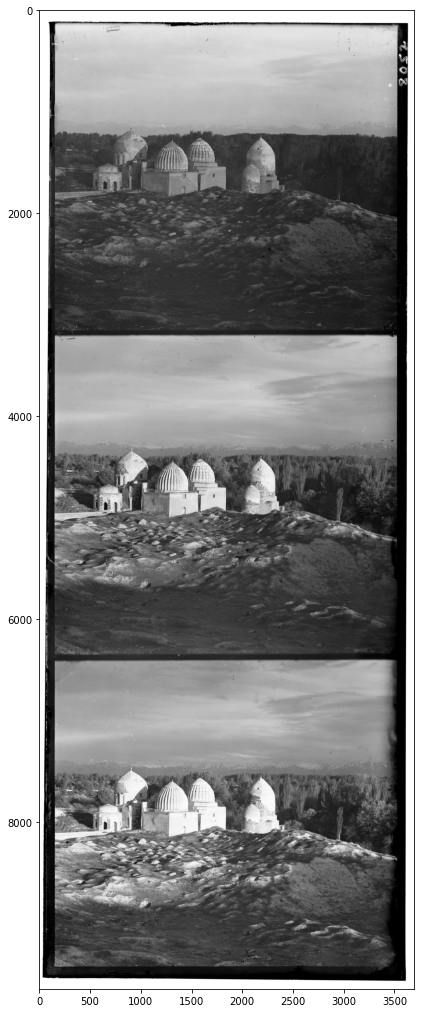

In [194]:
plt.figure(figsize=(7, 18))
plt.imshow(main_img, cmap='gray');

## Cropping main image to get different channels (red, green & blue)

In [195]:
img_b = main_img[:main_img.shape[0]//3, :]
img_g = main_img[main_img.shape[0]//3:2*main_img.shape[0]//3, :]
img_r = main_img[2*main_img.shape[0]//3:, :]

Here you can see the visualization of different channels

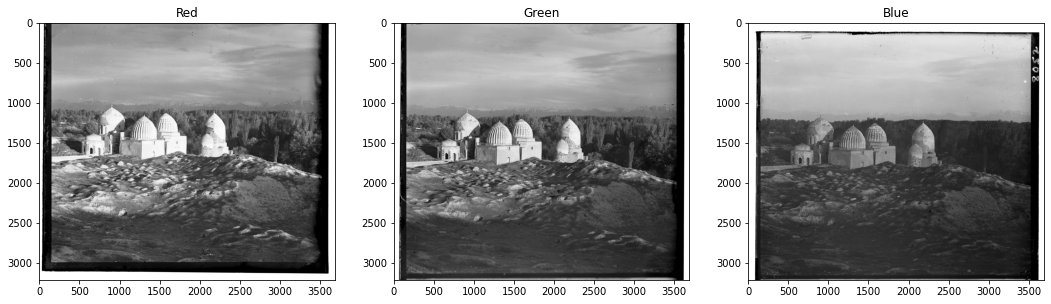

In [196]:
fig, ax = plt.subplots(1, 3, figsize=(18, 7))
for i, (img, label) in enumerate(zip([img_r, img_g, img_b], ['Red', 'Green', 'Blue'])):
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(label)

## Problem in alignment

if we stack channels on top of each other (without any modifications) we can see that they are not aligned!

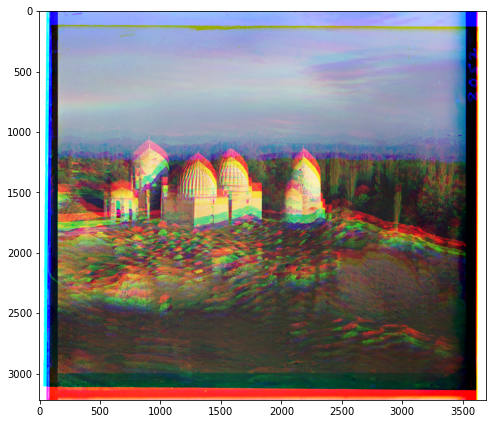

In [197]:
plt.figure(figsize=(8, 8))
plt.imshow(np.stack([img_r, img_g, img_b], axis=2)/65535);

## Downsample image 

In [198]:
def downsample(img, factor=2):
    return img[::factor, ::factor]

## Create center mask
this function creates a mask with given width and heigh which has ones in center and zeros on sides

In [199]:
def create_center_mask(height, width, boundry_remove_frac=0.15):
    mask = np.ones((height, width))
    mask[:int(boundry_remove_frac*height), :] = 0
    mask[:, :int(boundry_remove_frac*width)] = 0
    mask[-int(boundry_remove_frac*height):, :] = 0
    mask[:, -int(boundry_remove_frac*width):] = 0
    
    return mask

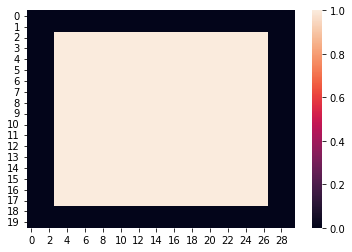

In [200]:
sns.heatmap(create_center_mask(20, 30, 0.1));

We use this mask in one of our distance measures for removing effect of boundries in loss

## Different Measures for calculating distance between two image

- L2 norm

In [201]:
def image_dist1(img1, img2):
    return np.sum((img1-img2)**2)

- L1 norm

In [202]:
def image_dist2(img1, img2):
    return np.sum(np.abs(img1 - img2))

- Normalized cross correlation 

<div style='font-size: 20px;'>
$
\frac{image_1}{\lVert image_1 \rVert} . \frac{image_2}{\lVert image_2 \rVert}
$
</div>

In [203]:
def image_dist3(img1, img2):
    return np.sum((img1/np.linalg.norm(img1)) * (img2/np.linalg.norm(img2)))

- cross correlation

<div style='font-size: 16px;'>
$
image_1 . image_2
$
</div>

In [204]:
def image_dist4(img1, img2):
    return np.dot(img1, img2)

- L2 norm + Ignoring high pixel-wise losses

Reason: when aligning two images with frames around (white and black frames), the overlap of white and black frames makes a huge loss and in this method we just simply ignore these high losses

In [205]:
def image_dist5(img1, img2, diff_th = 50000**2):
    diff = (img1 - img2)**2
    remove_mask = diff > diff_th
    diff[remove_mask] = 0
    
    return np.sum(diff)

- L2 norm + center mask

In [206]:
def image_dist6(img1, img2):
    return np.sum((img1-img2)**2 * create_center_mask(*img1.shape, 0.15))

**Best Distance Measure:**

After testing different methods and different distance metrics, I've found that "L2 norm + center mask" is the best among above metrics.

## Move image utilities

This function outputs (Left, Right, Up, Down) for $image_1$ and $image_2$ for a given position (which determines the position of $image_2$ on $image_1$)

In [207]:
def get_overlapped_boundries(img1, img2, pos_img2):
    w1, h1 = img1.shape
    w2, h2 = img2.shape
    i, j = pos_img2
    
    l1 = 0 if i < 0 else i
    r1 = w1 if i > 0 else w1+i
    u1 = 0 if j < 0 else j
    d1 = h1 if j > 0 else h1+j
            
    l2 = np.abs(i) if i < 0 else 0
    r2 = w2 if i < 0 else w2-i
    u2 = np.abs(j) if j < 0 else 0
    d2 = h2 if j < 0 else h2-j
    
    return l1, r1, u1, d1, l2, r2, u2, d2

This function outputs croped of $image_1$ and $image_2$ for a given position (which determines the position of $image_2$ on $image_1$) 

In [208]:
def get_overlapped_images(img1, img2, pos_img2):
    l1, r1, u1, d1, l2, r2, u2, d2 = get_overlapped_boundries(img1, img2, pos_img2)
    return img1[l1:r1, u1:d1], img2[l2:r2, u2:d2]

This function creates a new image for $image_2$ (with shape equal to $image_1$) and puts the cropped image of $image_2$ in the right place

In [209]:
def get_moved_img(img1, img2, pos_img2):
    l1, r1, u1, d1, l2, r2, u2, d2 = get_overlapped_boundries(img1, img2, pos_img2)
    
    tmp = np.zeros(img1.shape, dtype='uint32')
    tmp[l1:r1, u1:d1] = img2[l2:r2, u2:d2]
    
    return tmp

## Search for match

This function searches for the best match of $img_1$ and $img_2$. It searches in a give boundry (determined by **start** and **search_boundry**)

In [210]:
def search_match(img1, img2, start, search_boundry=20):
    s_i, s_j = start

    best_match, best_dist = start, np.inf    
    for i in range(s_i-search_boundry, s_i+search_boundry+1):
        for j in range(s_j-search_boundry, s_j+search_boundry+1):            
            new1, new2 = get_overlapped_images(img1, img2, (i, j))
            dist = image_dist6(new1, new2) / (new1.shape[0] * new1.shape[1])
            if dist < best_dist:
                best_match, best_dist = (i, j), dist

    return best_match

## Edge Detection

This function detects edges of the given image using *Sobel* filter *(This is basicly just convolving a matrix (filter) and the image)*

In [211]:
def get_edge_img(img):
    x_filter = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1],
    ])
    y_filter = x_filter.T
    
    result_x = signal.convolve2d(img, x_filter, mode='valid')
    result_y = signal.convolve2d(img, y_filter, mode='valid')
    edge_img = np.sqrt(result_x**2 + result_y**2)
    edge_img = edge_img * img.max() / edge_img.max()
    
    return edge_img

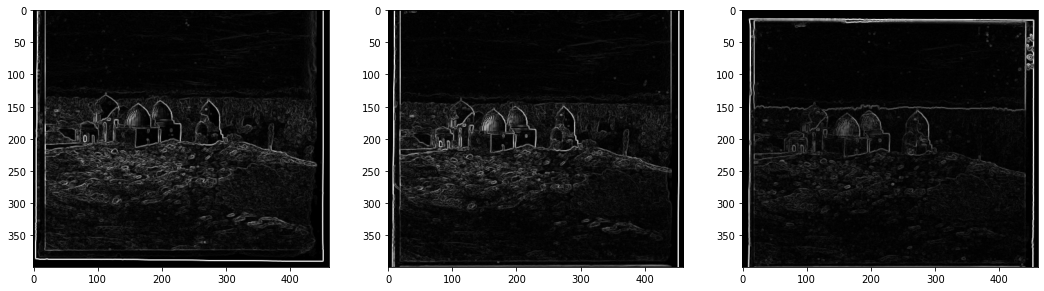

In [212]:
edge_r, edge_g, edge_b = get_edge_img(downsample(img_r, 8)), get_edge_img(downsample(img_g, 8)), get_edge_img(downsample(img_b, 8))
fig, ax = plt.subplots(1, 3, figsize=(18, 7))
for i, img in enumerate([edge_r, edge_g, edge_b]):
    ax[i].imshow(img, cmap='gray')

## Auto Crop 

This function crops the image by removing outer frames and unaligned colors in the sides (it crops using all 3 channels to achieve a better performance)

Steps of this functions:
1. Edge detection on each channel
2. Using edges from `1`, we search for lines in each channel. (Note that the boundry of search is determined by the parameter `search_boundry`)
    - This is done by taking the average value in each column (and row) and comparing it with a threshold (determined by parameter `th`)
    - **Note:** Although, we could use methods like Hough Transform to find these lines. Besides, another method would be just working on the gray scale image and ...). Also another good approach is working on std (or variance) of each row (and column) ...
   
**Enhancement:** For a better line detection, we use max pooling on the result of edge detection. The main reason that I'm doing this here is because of a better detection of lines which are not straight in horizontal or vertical axis. 

In [213]:
def max_pool(mat, size):
    result = mat.copy()
    for i in range(0, mat.shape[0], size):
        for j in range(0, mat.shape[1], size):
            i2, j2 = min(i+size, mat.shape[0]), min(j+size, mat.shape[1])
            result[i:i2, j:j2] = mat[i:i2, j:j2].max()
            
    return result

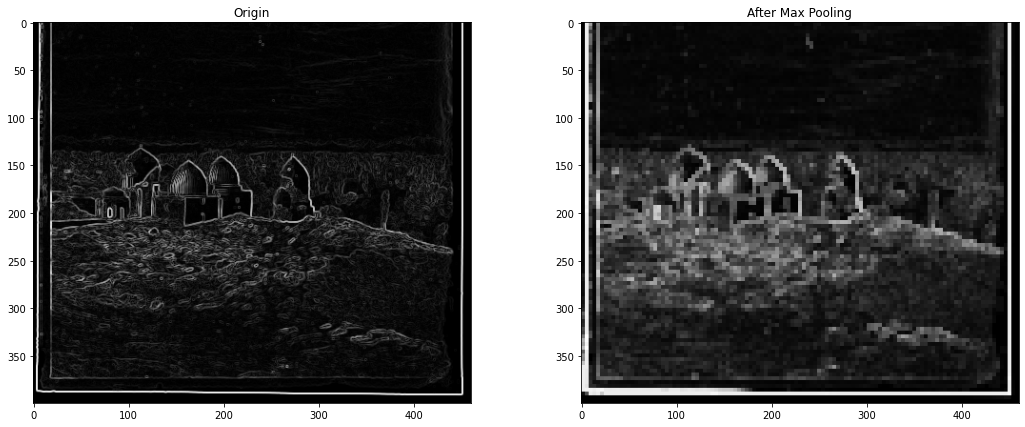

In [214]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
ax[0].imshow(edge_r, cmap='gray')
ax[1].imshow(max_pool(edge_r, 4), cmap='gray')
ax[0].set_title('Origin')
ax[1].set_title('After Max Pooling');

In [215]:
def image_auto_crop(img_r, img_g, img_b, th=0.2, search_boundry=0.2, max_pool_size=4):
    # Edges of each channel
    moved_edge_r = get_edge_img(img_r)
    moved_edge_r = max_pool(moved_edge_r/moved_edge_r.max(), max_pool_size)
    moved_edge_g = get_edge_img(img_g)
    moved_edge_g = max_pool(moved_edge_g/moved_edge_g.max(), max_pool_size)
    moved_edge_b = get_edge_img(img_b)
    moved_edge_b = max_pool(moved_edge_b/moved_edge_b.max(), max_pool_size)
    
    # Mean in each row and column
    avg_j_r = moved_edge_r.mean(axis=0)
    avg_i_r = moved_edge_r.mean(axis=1)
    avg_j_g = moved_edge_g.mean(axis=0)
    avg_i_g = moved_edge_g.mean(axis=1)
    avg_j_b = moved_edge_b.mean(axis=0)
    avg_i_b = moved_edge_b.mean(axis=1)

    # Find left, right, up & down
    h, w = moved_edge_r.shape
    l, r, u, d = 0, w-1, 0, h-1
    for i in range(0, int(search_boundry*h)):
        if avg_i_r[i] > th or avg_i_g[i] > th or avg_i_b[i] > th:
            u = i
    for i in range(h-1, int((1-search_boundry)*h), -1):
        if avg_i_r[i] > th or avg_i_g[i] > th or avg_i_b[i] > th:
            d = i
    for i in range(0, int(search_boundry*w)):
        if avg_j_r[i] > th or avg_j_g[i] > th or avg_j_b[i] > th:
            l = i
    for i in range(w-1, int((1-search_boundry)*w), -1):
        if avg_j_r[i] > th or avg_j_g[i] > th or avg_j_b[i] > th:
            r = i
    
    return img_r[u:d, l:r], img_g[u:d, l:r], img_b[u:d, l:r]

**Note:** Each method has some pros and cons. The method that we used here, removes frames perfectly but sometimes it removes more than enough! Some other methods doesn't perform well on removing frames but guaranty that they won't remove anything besides frames. I personaly like the first method in order to get a better result.

## Search using Pyramid 

Here we try to find the best match in images. To achieve this, we first downsample to image to work on an image with a lower dimension. After finding the match for the downsampled image, we use this result to find the match in higher levels.

**Better search:** for a better search I use edge detection first and then find the best match of the two images (edge images). This will result to a much better matching

In [216]:
def pyramid_search(img_r, img_g, img_b, num_levels=3, search_boundries=[5, 10, 20]):
    assert num_levels == len(search_boundries)
    
    if num_levels > 1:
        g_position, r_position, matched_images = pyramid_search(
            downsample(img_r, factor=2),
            downsample(img_g, factor=2),
            downsample(img_b, factor=2),
            num_levels-1,
            search_boundries[1:]
        )
    else:
        g_position, r_position, matched_images = (0, 0), (0, 0), []
        
    g_start_position = (g_position[0]*2, g_position[1]*2)
    r_start_position = (r_position[0]*2, r_position[1]*2)
    
    edge_r, edge_g, edge_b = get_edge_img(img_r), get_edge_img(img_g), get_edge_img(img_b)
    g_edge_match_pos = search_match(edge_b, edge_g, g_start_position, search_boundries[0])
    r_edge_match_pos = search_match(edge_b, edge_r, r_start_position, search_boundries[0])

    stacked_img = np.stack([get_moved_img(img_b, img_r, r_edge_match_pos), get_moved_img(img_b, img_g, g_edge_match_pos), img_b], axis=2)
    matched_images.append(stacked_img)
    
    return g_edge_match_pos, r_edge_match_pos, matched_images

# Running Pyramic Search + Visualization of Pyramid

In [217]:
g_matched_position, r_matched_position, pyramid_images = pyramid_search(img_r, img_g, img_b, num_levels=5, search_boundries=[2, 4, 8, 16, 32])

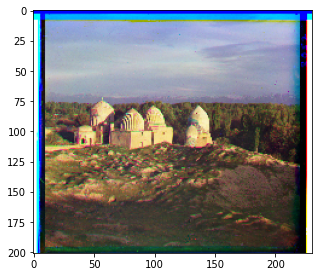

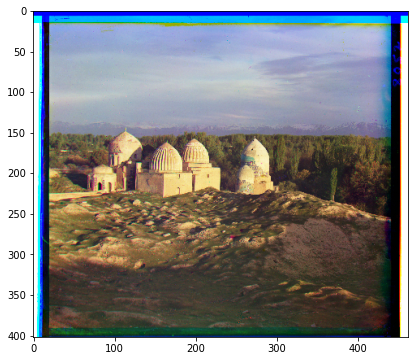

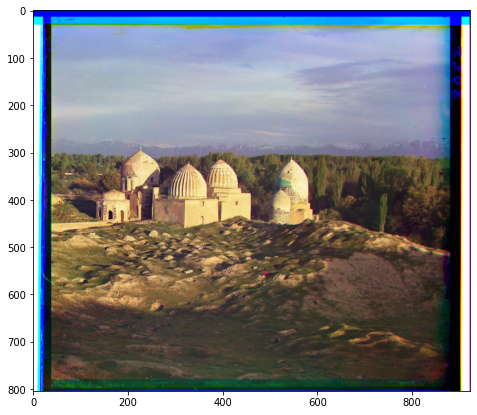

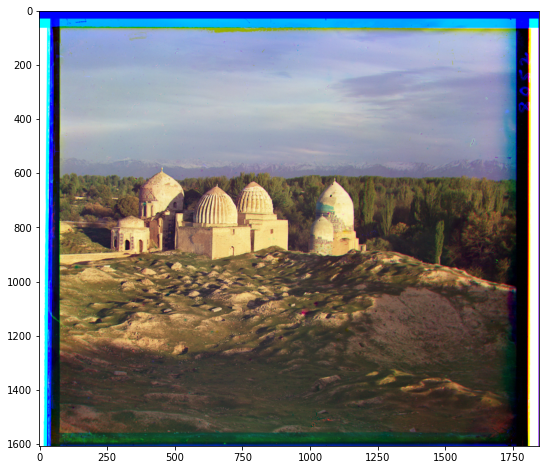

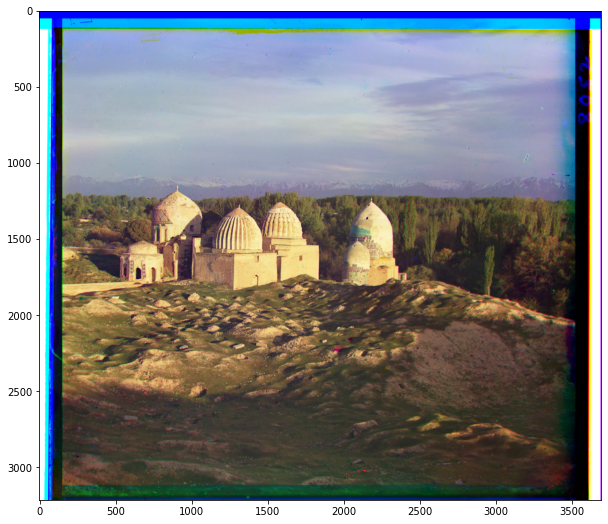

In [218]:
for i, img in enumerate(pyramid_images):
    plt.figure(figsize=(i*2+5, i+5))
    plt.imshow(img/img.max());
    plt.show()

### Comparing edge images after matching

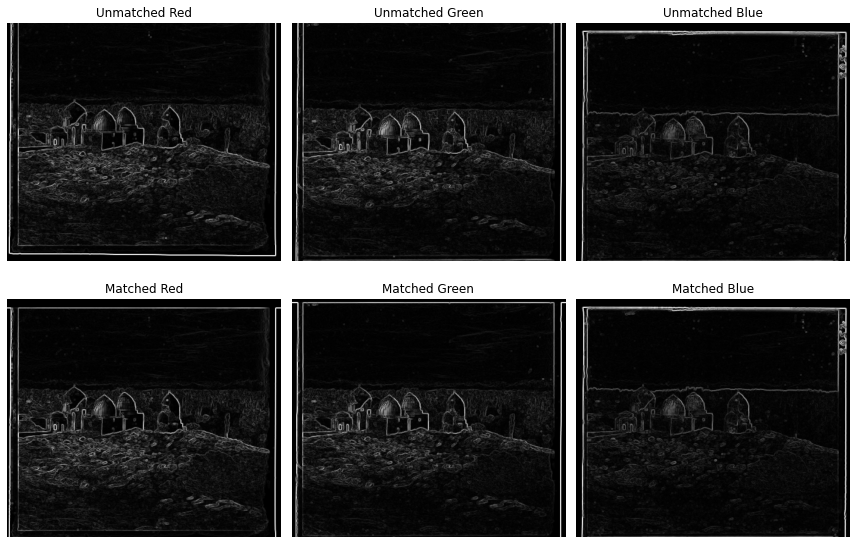

In [219]:
edge_r, edge_g, edge_b = get_edge_img(downsample(img_r, 8)), get_edge_img(downsample(img_g, 8)), get_edge_img(downsample(img_b, 8))

moved_edge_r = get_edge_img(downsample(get_moved_img(img_b, img_r, r_matched_position), 8))
moved_edge_g = get_edge_img(downsample(get_moved_img(img_b, img_g, g_matched_position), 8))
moved_edge_b = get_edge_img(downsample(img_b, 8))

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for i, (img, label) in enumerate(zip([edge_r, edge_g, edge_b], ['Unmatched Red', 'Unmatched Green', 'Unmatched Blue'])):
    ax[0][i].imshow(img, cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title(label)
for i, (img, label) in enumerate(zip([moved_edge_r, moved_edge_g, moved_edge_b], ['Matched Red', 'Matched Green', 'Matched Blue'])):
    ax[1][i].imshow(img, cmap='gray')
    ax[1][i].axis('off')
    ax[1][i].set_title(label)
    
fig.tight_layout()

## Auto Crop

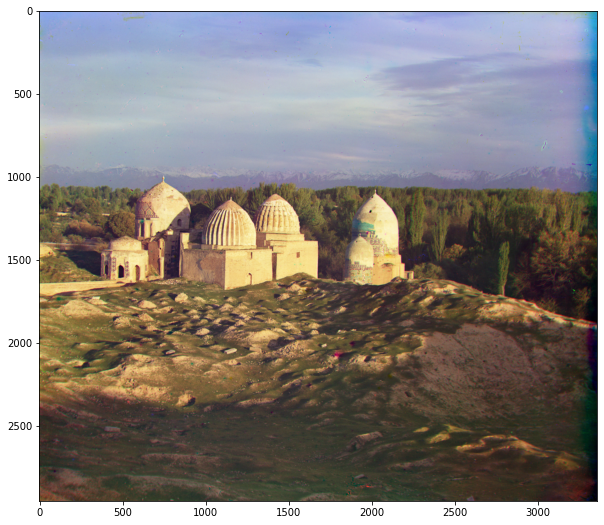

In [220]:
final_img = np.stack([
    *image_auto_crop(
        get_moved_img(img_b, img_r, r_matched_position),
        get_moved_img(img_b, img_g, g_matched_position),
        img_b, th=0.1, search_boundry=0.1, max_pool_size=10
    )
], axis=2)
plt.figure(figsize=(10, 10))
plt.imshow(final_img/final_img.max());